## Task 1

In [1]:
from keras import datasets
import numpy as np
#from keras.models import Sequential
#from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from numpy.random import default_rng as rng
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

## Load Dataset

In [2]:
def load_dataset():

    #rng = default_rng()
    #encoder = OneHotEncoder()
    #encoder2= OneHotEncoder()

    data = datasets.mnist.load_data()

    (X_train, y_train), (X_test, y_test) = data

    #print(datasets.mnist.load_data())

    X_train = X_train / 255
    X_test = X_test / 255

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    X_train = np.reshape(X_train, [60000, 28 * 28])
    X_test = np.reshape(X_test, [10000, 28 * 28])

    #encoder = encoder.fit_transform(y_train.reshape(1, -1))
    #encoder2= encoder2.fit_transform(y_test.reshape(1, -1))
    #y_train = np.reshape(y_train, [60000, 1])
    #y_test = np.reshape(y_test, [10000, 1])

    print(X_train[0])
    print(y_test)

    print(y_train.shape)
    
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = load_dataset()

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

## Relu Layer

In [4]:
class Activation_Layer_ReLU:
    
    def forward_pass(self, x):
        
        self.x = x
        
        return np.maximum(0, x)
    
    def backward_pass(self, dvalues):
        
        """self.d_relu = dvalues.copy()
        
        self.d_relu[self.x <= 0] = 0
        
        return self.d_relu"""
        
        #return (x > 0) * 1
        
        return (np.greater(self.x, 0).astype(int)) * dvalues
        

## Sigmoid Layer

In [5]:
class Activation_Layer_Sigmoid:
    
    def forward_pass(self, x):
        
        #print("TEST 2")
        self.sigmoid = 1 / (1 + np.exp(-x))
        
        return self.sigmoid
    
    def backward_pass(self, dvalues):
        
        #print("Test")
        
        return (self.sigmoid * (1 - self.sigmoid)) * dvalues
        #return self.forward_pass(dvalues) * (1 - self.forward_pass(dvalues))


## Softmax Layer

In [6]:
class Activation_Layer_Softmax:
    
    def forward_pass(self, x):
        
        exponents = np.exp(x - np.max(x, axis = 1, keepdims = True))
        
        self.softmax_out = exponents / np.sum(exponents, axis = 1, keepdims = True)
        
        return self.softmax_out
    
    def backward_pass(self, dvalues):
        
        #softmax = self.softmax(x)
        
        #return np.diag(softmax) + (softmax * softmax.reshape(14000, 784))
        
        """print("DV:", dvalues.shape)
        
        jacobian = dvalues[:, :, None] * dvalues[:, None, :]
        #print("Jaco", jacobian.shape)
        
        iy, ix = np.diag_indices_from(dvalues)
        jacobian[:, iy, ix] = dvalues * (1.0 - dvalues)
        
        self.dinputs = np.sum(jacobian, axis = 1)"""
        
        self.dinputs = np.empty_like(dvalues) # Create empty array same size as input gradients
        
        #print(self.softmax_out.shape)
        
        for idx, (single_output, single_dvalue) in enumerate(zip(self.softmax_out, dvalues)):
            
            single_output = single_output.reshape(-1, 1) # Flatten output
            
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T) # Create a jacobian matrix for each output 
            
            self.dinputs[idx] = np.dot(jacobian_matrix, single_dvalue) # Calculate sample-wise gradients
        
        #print("D_SF", self.dinputs.shape)
        
        return self.dinputs * dvalues
    
        """#d_vector = dvalues.flatten()
        #d_matrix = np.tile(dvalues, dvalues.shape[1])
        
        #test = np.diag(dvalues) - np.dot(d_matrix, d_matrix.T)
        
        #print("TEST:", test)
        
        s_max = self.softmax_out.copy()
        
        si_sj = np.dot(self.softmax_out.flatten(), self.softmax_out.flatten().T)
        
        print("AAAAAAAAAAAAAAAAAA", self.softmax_out.T.flatten().shape)
        
        #print(s)
        print("PPPPPPPPPPPPP", si_sj.shape)
        s_der = np.diag(self.softmax_out.flatten()) - si_sj
        print("S_DER", np.diag(self.softmax_out).shape)
        
        #s = self.softmax_out.reshape(-1, 1)
        
        #self.dinputs = np.diagflat(s) - np.dot(s, s.T)
        self.test = s_der
        
        print("######", self.test.shape, self.dinputs.shape)"""


## Dense Layer

In [7]:
class Layer_Dense:
    
    def __init__(self, n_inputs, n_neurons):
        
        #self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        #self.weights = np.random.normal(size = (n_inputs, n_neurons))
        
        self.weights = (np.random.randn(n_inputs, n_neurons) * np.sqrt(2/n_neurons)) #He Initialisation
        #self.weights = (np.random.normal(loc = 0, scale = 0.5, size = (n_inputs, n_neurons)) * np.sqrt(2/n_neurons)) #He Initialisation
        #self.weights = np.random.uniform(-1.0, 1.0, size = (n_inputs, n_neurons))
        #self.biases = np.zeros((1, n_neurons))
        self.biases = 0.01 * (np.random.randn(1, n_neurons))
        
        #print(self.weights)

    def forward_pass(self, x):
        
        self.x = x
        
        return np.dot(x, self.weights) + self.biases
    
    def backward_pass(self, dvalues):
        
        #print(self.x, dvalues.shape)
        
        N = len(self.x)
        
        self.dweights = (1/N) * np.dot(self.x.T, dvalues)
        self.dbiases = (1/N) * np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs = (1/N) * np.dot(dvalues, self.weights.T)
        
        #self.dinputs = np.dot(dvalues, self.weights.T) * (1 - np.power(np.maximum(0, self.x), 2))
        
        #print("dIN", self.dinputs.shape)
        
        return self.dinputs

## Dropout Layer

In [8]:
class Layer_Dropout:
    
    def __init__(self, success_rate):
        
        self.success_rate = 1 - success_rate
        
    def forward_pass(self, x):
        
        self.x = x
        self.scale_mask = np.random.binomial(1, self.success_rate, size = self.x.shape) / self.success_rate
        
        return self.x * self.scale_mask
        
    def backward_pass(self, dvalues):
        
        self.dinputs = dvalues * self.scale_mask
        
        return self.dinputs
    

## Calcualting Mean Loss

In [9]:
class Loss:
    
    def calculate_mean_loss(self, y_pred, y_true):
        
        #mean_loss = np.mean(self.forward_propogation(y_pred, y_true))
        mean_loss = self.forward_pass(y_pred, y_true)
        
        return mean_loss
        

## Categorical Cross Entropy Loss

In [10]:
class Loss_Cross_Entropy(Loss):
    
    def forward_pass(self, y_pred, y_true):
        
        N = len(y_pred)
        
        """if len(y_true.shape) == 1:
            
            #print("A:", y_pred.shape, y_true.shape, range(samples))
            
            confidence = y_pred[range(N), y_true]
        
        elif len(y_true.shape) == 2:
            
            confidence = np.sum(y_pred * y_true, axis = 1)
            
        neg_log_likelihood = np.mean(-np.log(confidence))"""
        
        #neg_log_likelihood = - np.sum(np.dot(y_true, np.log(y_pred)))
        #-sum([p[i]*log(q[i])
        
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        #neg_log_likelihood = np.mean((-1/N) * (np.sum(y_true * np.log(y_pred), axis = 1)))
        
        #neg_log_likelihood = np.mean(-np.log((-1) * (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))))
        
        #neg_log_likelihood = np.mean((1/N) * -np.sum(np.log(y_pred_clipped) * y_true + np.log(1 - y_pred_clipped) * (1 - y_true), axis = 1))
        
        neg_log_likelihood = np.mean((-1/N) * np.sum(np.dot(y_true.T, np.log(y_pred_clipped))
                                             + np.dot((1. - y_true).T, np.log(1 - y_pred_clipped)), axis = 1))
        
        return neg_log_likelihood
     
    def backward_pass(self, dvalues, y_true):
        
        N = len(dvalues)
        labels = len(dvalues[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = (-y_true / dvalues)
        self.dinputs = self.dinputs / N

        return self.dinputs
        

## Cross Entropy Loss + Softmax Activation Layer

In [135]:
class Activation_Softmax_Layer_Loss_Cross_Entropy:
    
    def __init__(self):
        self.activation = Activation_Layer_Softmax()
        self.loss = Loss_Cross_Entropy()
        
    def forward_pass(self, x, y_true):
        
        self.x = x
        
        self.softmax_output = self.activation.forward_pass(x)
        self.mean_loss = self.loss.calculate_mean_loss(self.softmax_output, y_true)
        
        return self.softmax_output
        
    def backward_pass(self, y_pred, y_true):
        
        N = len(y_pred)
        
        """if len(y_true.shape) == 2:
            
            y_true = np.argmax(y_true, axis = 1)
            
        self.dinputs = dvalues.copy()
        
        self.dinputs[range(N), y_true] -= 1
        
        self.dinputs = (1/N) * self.dinputs
        
        if len(y_true.shape) == 2:
            
            y_true = np.argmax(y_true, axis = 1)"""
        
        #print("SF", self.softmax_output.T, y_true.shape)
        
        #self.dinputs = (1/N) * ((self.softmax_output) * self.activation.backward_pass(dvalues))
        
        self.dinputs = y_pred - y_true
        
        #self.dinputs = np.mean((1/N) * np.sum(np.dot(self.x.T, y_pred - y_true), axis = 1))
        
        #self.dinputs = (1/N) * np.sum(np.dot((dvalues - y_true), self.x.T), axis = 1)
        
        #print(self.dinputs.shape)
        
        return self.dinputs
    

## Stochastic Gradient Descent Optimiser

In [136]:
class Optimiser_SGD:
    
    def __init__(self, learning_rate = 0.5, decay = 0, momentum = 0):
        
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    def update_learning_rate(self): #Learning rate decay
        
        if self.decay:
            
            self.current_learning_rate = self.learning_rate * (1/(1 + self.decay * self.iterations))
    
    def update_iterations(self):
        
        self.iterations += 1
    
    def update_values(self, layer):
        
        if self.momentum:
            
            if not hasattr(layer, "weight_momentum"):
                
                layer.weight_momentum = np.zeros_like(layer.weights)
                layer.bias_momentum = np.zeros_like(layer.biases)
                
            new_weights = (self.momentum * layer.weight_momentum) - (self.current_learning_rate * layer.dweights)
            layer.weight_momentum = new_weights
            
            new_biases = (self.momentum * layer.bias_momentum) - (self.current_learning_rate * layer.dbiases)
            layer.bias_momentum = new_biases
            
        else:
            
            new_weights -= self.learning_rate * layer.dweights
            new_biases -= self.learning_rate * layer.dbiases
        
        layer.weights += new_weights
        layer.biases += new_biases
        
        """#print("A")
        #print(layer.weights)
        
        #print("####################################")
        #print(layer.dweights)
        
        layer.weights -= self.learning_rate * layer.dweights
        layer.biases -= self.learning_rate * layer.dbiases
        
        #print("B")
        #print(layer.weights)"""
        
        #return layer.weights, layer.biases
        

## Mini Batch Gradient Descent Optimiser

In [137]:
class Optimiser_Mini_Batch_GD:
    
    def __init__(self, learning_rate = 0.5, batch_size = 32):
        
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        
    def generate_batches(self, X, y):
        
        mini_batches = []
        
        X, y = shuffle(X, y)
        
        for idx in range(0, X.shape[0], self.batch_size):
            
            X_batch = X[idx:idx + self.batch_size]
            y_batch = y[idx:idx + self.batch_size].reshape(-1, 1)
        
        mini_batches.append((X_batch, y_batch))
        
        return mini_batches
        
        """mini_batches = []
        data = np.vstack((X.T, y.T))
        np.random.shuffle(data)
        
        n_batches = data.shape[0] // self.batch_size
        
        idx = 0
        
        for idx in range(n_batches + 1):
            
            mini_batch = data[idx * batch_size:(idx + 1) * batch_size, :]
            
            X_batch = mini_batch[:, :-1]
            y_batch = mini_batch[:, :-1].reshape((-1, 1))
            
            mini_batches.append((X_batch, y_batch))
            
        if data.shape[0] % batch_size != 0:
                
            mini_batch = data[idx * batch_size:data.shape[0]]
                
            X_batch = mini_batch[:, :-1]
            y_batch = mini_batch[:, :-1].reshape((-1, 1))
            
            mini_batches.append((X_batch, y_batch))
            
        return mini_batches"""
        
        """mini_batches = []
        #data = np.vstack((X.T, y.T))
        #np.random.shuffle(data)
        
        X, y = shuffle(X, y)
        
        n_batches = X.shape[0] // self.batch_size
        
        idx = 0
        
        for idx in range(n_batches + 1):
            
            #mini_batch = data[idx * batch_size:(idx + 1) * batch_size, :]
            
            X_batch = X[idx * self.batch_size:(idx + 1) * self.batch_size, :]
            y_batch = y[idx * self.batch_size:(idx + 1) * self.batch_size, :].reshape((-1, 1))
            
            mini_batches.append((X_batch, y_batch))
            
        if X.shape[0] % batch_size != 0:
                
            #mini_batch = data[idx * batch_size:data.shape[0]]
                
            X_batch = X[idx * self.batch_size:X.shape[0]]
            y_batch = y[idx * self.batch_size:y.shape[0]].reshape((-1, 1))
            
            mini_batches.append((X_batch, y_batch))
            
        return mini_batches"""
    
    def mini_batch_gradient_descent(self, X, y, layer):
        
        #error_list = []
        
        mini_batches = self.generate_batches(X, y)
        
        for batch in mini_batches:
            
            x_batch, y_batch = batch
            
            layer.weights -= self.learning_rate * layer.dweights
            layer.biases -= self.learning_rate * layer.dbiases
            

## Neural Network Class

In [172]:
class NeuralNetwork:
    
    def __init__(self, learning_rate, batch_size, epochs, input_layer_size, output_layer_size, neuron_size):
        
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.input_layer_size = input_layer_size
        self.output_layer_size = output_layer_size
        self.neuron_size = neuron_size
        
        self.loss_history = []
        self.accuracy_history = []
    
    def fit(self, X_train, y_train):
        
        batches = self.generate_batches(X_train, y_train, self.batch_size)
        
        print(len(batches))
        
        self.generate_layers()
        
        idx = 0
        
        for batch in batches:
            
            idx += 1
            
            print("Batch", idx, "of", len(batches))
            
            X_train, y_train = batch

            for epoch in range(self.epochs):

                #print("ReLU")
                self.dense_layer1_forward = self.dense_layer1.forward_pass(X_train)    
                self.activation_layer1_forward = self.activation_layer1.forward_pass(self.dense_layer1_forward)

                self.dropout_layer1_forward = self.dropout_layer1.forward_pass(self.activation_layer1_forward)

                #print(X_train.shape, dense_layer1_forward.shape, activation_layer1_forward.shape)

                #print("Sig")
                self.dense_layer2_forward = self.dense_layer2.forward_pass(self.dropout_layer1_forward)
                self.activation_layer2_forward = self.activation_layer2.forward_pass(self.dense_layer2_forward)

                #print(activation_layer1_forward)

                #print("Soft")
                self.dense_layer3_forward = self.dense_layer3.forward_pass(self.activation_layer2_forward)
                #activation_layer3_forward = activation_layer3.forward_pass(dense_layer3_forward)

                #print(y_test.shape)

                #print(activation_layer3_forward)

                #print("Loss")
                #loss = loss_function.calculate_mean_loss(activation_layer3_forward, y_train)

                self.activation_layer3_forward = self.loss_activation.forward_pass(self.dense_layer3_forward, y_train)

                loss = self.loss_activation.mean_loss

                #print("Loss:", loss)

                self.test_y_pred = self.activation_layer3_forward.copy()
                self.test_y_true = y_train.copy()

                y_pred = np.argmax(self.activation_layer3_forward, axis = 1)
                y_valid = np.argmax(y_train, axis = 1)

                #accuracy = np.mean(y_pred == y_valid)
                accuracy = accuracy_score(y_valid, y_pred)

                #print("Accuracy:", accuracy)

                self.loss_history.append(loss)
                self.accuracy_history.append(accuracy)

                if epoch % 10 == 0:

                    print("epoch:", epoch, "loss:", loss, "acc:", accuracy)#, "lr:", optimiser.current_learning_rate)


                #Backward Pass

                #print("Soft Back")
                #loss_activation_backward = loss_function.backward_propogation(activation_layer3_forward, y_train)
                self.loss_activation_backward = self.loss_activation.backward_pass(self.activation_layer3_forward, y_train)

                #activation_layer3_backward = activation_layer3.backward_pass(loss_activation_backward, activation_layer3_forward)    
                self.dense_layer3_backward = self.dense_layer3.backward_pass(self.loss_activation_backward)

                #print("Sig Back")
                self.activation_layer2_backward = self.activation_layer2.backward_pass(self.dense_layer3_backward)
                self.dense_layer2_backward = self.dense_layer2.backward_pass(self.activation_layer2_backward)

                #print("ReLU Back")

                self.dropout_layer1_backward = self.dropout_layer1.backward_pass(self.dense_layer2_backward)

                self.activation_layer1_backward = self.activation_layer1.backward_pass(self.dropout_layer1_backward)    
                self.dense_layer1.backward_pass(self.activation_layer1_backward)

                #print(dense_layer1.weights.shape)

                #dense_layer3_backward = dense_layer3.backward_pass(loss_function.calculate_mean_loss(activation_layer3_forward, y_train), y_train)

                #print("BEFORE")
                #print(dense_layer1.weights)

                #old_weights = dense_layer1.weights.copy()

                #dense_layer1.set_weights(optimiser.update_values(dense_layer1)[0])

                """optimiser.mini_batch_gradient_descent(X_train, y_train, dense_layer1)
                optimiser.mini_batch_gradient_descent(X_train, y_train, dense_layer2)
                optimiser.mini_batch_gradient_descent(X_train, y_train, dense_layer3)"""

                self.optimiser.update_learning_rate() # For learning rate decay

                self.optimiser.update_values(self.dense_layer1)
                self.optimiser.update_values(self.dense_layer2)
                self.optimiser.update_values(self.dense_layer3)

                self.optimiser.update_iterations()


                #print(dense_layer1.weights)

                """if iteration % 50 == 0:

                    print("iteration:", iteration, "loss:", loss, "acc:", accuracy)

                #if iteration % 250 == 0:
                loss_history.append(loss)
                accuracy_history.append(accuracy)


                """

            print("epoch:", epoch, "loss:", loss, "acc:", accuracy, "\n")
        
    def predict(self, X_test):
        
        self.dense_layer1_forward = self.dense_layer1.forward_pass(X_train)    
        self.activation_layer1_forward = self.activation_layer1.forward_pass(self.dense_layer1_forward)

        self.dropout_layer1_forward = self.dropout_layer1.forward_pass(self.activation_layer1_forward)

        self.dense_layer2_forward = self.dense_layer2.forward_pass(self.dropout_layer1_forward)
        self.activation_layer2_forward = self.activation_layer2.forward_pass(self.dense_layer2_forward)

        self.dense_layer3_forward = self.dense_layer3.forward_pass(self.activation_layer2_forward)
        self.activation_layer3_forward = self.loss_activation.forward_pass(self.dense_layer3_forward, y_train)

        loss = self.loss_activation.mean_loss

        self.test_y_pred = self.activation_layer3_forward.copy()
        self.test_y_true = y_train.copy()

        y_pred = np.argmax(self.activation_layer3_forward, axis = 1)
        y_valid = np.argmax(y_train, axis = 1)

        accuracy = accuracy_score(y_valid, y_pred)
        
        print("loss:", loss, "acc:", accuracy)
    
    def generate_layers(self):
        
        self.dense_layer1 = Layer_Dense(X_train.shape[1], self.neuron_size)

        self.activation_layer1 = Activation_Layer_ReLU()

        self.dropout_layer1 = Layer_Dropout(0.1)

        self.dense_layer2 = Layer_Dense(self.neuron_size, self.neuron_size)

        self.activation_layer2 = Activation_Layer_Sigmoid()

        self.dense_layer3 = Layer_Dense(self.neuron_size, self.output_layer_size)

        self.activation_layer3 = Activation_Layer_Softmax()

        #self.loss_function = Loss_Cross_Entropy()

        self.loss_activation = Activation_Softmax_Layer_Loss_Cross_Entropy()

        self.optimiser = Optimiser_SGD(learning_rate = self.learning_rate, decay = 0.001, momentum = 0.9)
        #self.optimiser = Optimiser_Mini_Batch_GD(learning_rate = self.learning_rate, batch_size = self.batch_size)
        
    
    def generate_batches(self, X, y, batch_size):
        
        mini_batches = []
        
        X, y = shuffle(X, y)
        
        for idx in range(0, X.shape[0], batch_size):
            
            X_batch = X[idx:idx + batch_size]
            y_batch = y[idx:idx + batch_size]
        
            mini_batches.append((X_batch, y_batch))
        
        return mini_batches
        

In [178]:
learning_rate = 0.6
batch_size = 2500
epochs = 100
input_layer_size = X_train.shape[1]
neuron_size = 250
output_layer_size = 10

network = NeuralNetwork(learning_rate = learning_rate, batch_size = batch_size, epochs = epochs, 
                        input_layer_size = input_layer_size, neuron_size = neuron_size, 
                        output_layer_size = output_layer_size)

In [179]:
network.fit(X_train, y_train)

24
Batch 1 of 24
epoch: 0 loss: 6.6920361661333505 acc: 0.1148
epoch: 10 loss: 13.753458128907798 acc: 0.1288
epoch: 20 loss: 19.662838933332985 acc: 0.1172
epoch: 30 loss: 18.207009291932117 acc: 0.1728
epoch: 40 loss: 18.516101708371362 acc: 0.176
epoch: 50 loss: 17.431021267478123 acc: 0.3284
epoch: 60 loss: 17.48917399998654 acc: 0.5984
epoch: 70 loss: 16.96570096923156 acc: 0.6632
epoch: 80 loss: 17.093929963685305 acc: 0.7488
epoch: 90 loss: 16.857947891095456 acc: 0.7732
epoch: 99 loss: 17.003383417177677 acc: 0.7948 

Batch 2 of 24
epoch: 0 loss: 16.731519213035742 acc: 0.7672
epoch: 10 loss: 16.50434300208501 acc: 0.7756
epoch: 20 loss: 16.292883075147245 acc: 0.7848
epoch: 30 loss: 16.011422314704692 acc: 0.8096
epoch: 40 loss: 15.786602160169668 acc: 0.8172
epoch: 50 loss: 15.66240682171967 acc: 0.8148
epoch: 60 loss: 15.547523319308738 acc: 0.8228
epoch: 70 loss: 15.338402826249908 acc: 0.8184
epoch: 80 loss: 15.209173166774494 acc: 0.8296
epoch: 90 loss: 15.04651370599667 

epoch: 60 loss: 10.91012010632614 acc: 0.8864
epoch: 70 loss: 10.947796448196756 acc: 0.8912
epoch: 80 loss: 10.890022197403525 acc: 0.8908
epoch: 90 loss: 10.920111252318472 acc: 0.898
epoch: 99 loss: 10.913473272298251 acc: 0.8872 

Batch 17 of 24
epoch: 0 loss: 10.789867168107452 acc: 0.8664
epoch: 10 loss: 10.639295588502065 acc: 0.8696
epoch: 20 loss: 10.690486655565909 acc: 0.8668
epoch: 30 loss: 10.686056709571073 acc: 0.8716
epoch: 40 loss: 10.662925018040983 acc: 0.8664
epoch: 50 loss: 10.650343158345814 acc: 0.8752
epoch: 60 loss: 10.675384766222944 acc: 0.868
epoch: 70 loss: 10.658777125307264 acc: 0.874
epoch: 80 loss: 10.628122396188633 acc: 0.8792
epoch: 90 loss: 10.640082968881298 acc: 0.8784
epoch: 99 loss: 10.608147264719365 acc: 0.876 

Batch 18 of 24
epoch: 0 loss: 10.760831165365598 acc: 0.8688
epoch: 10 loss: 10.737060354069422 acc: 0.8696
epoch: 20 loss: 10.724990856981105 acc: 0.8812
epoch: 30 loss: 10.69528894473803 acc: 0.8676
epoch: 40 loss: 10.687437266545102

In [180]:
network.predict(X_test)

loss: 10.576409802489442 acc: 0.8785833333333334


In [34]:
import pandas as pd
from sklearn.metrics import f1_score

pd.options.display.max_seq_items = 100

x = np.argmax(network.test_y_pred, axis = 1)
y = np.argmax(network.test_y_true, axis = 1)

#print("X\n")
#print([*x])

#print("Y\n")
#print([*y])

#print(np.mean(x == y))

print(f1_score(y, x, average='micro'))

0.5934166666666667


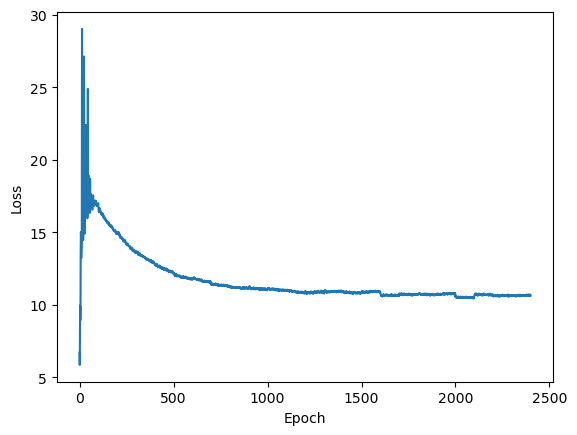

In [181]:
#loss_history, accuracy_history, epochs = network.get_histories()

plt.plot(range(int(network.epochs) * (24)), network.loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

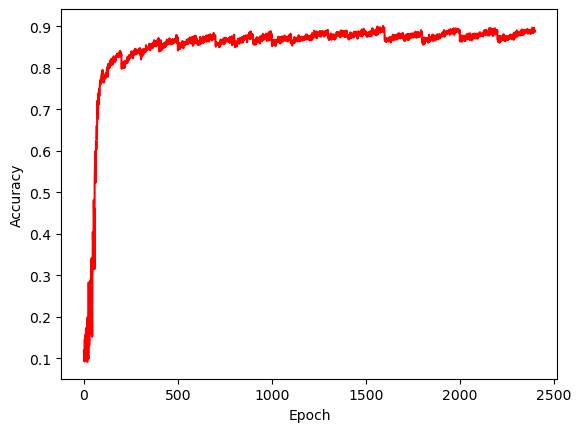

In [182]:
plt.plot(range(int(network.epochs) * (24)), network.accuracy_history, color = "red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

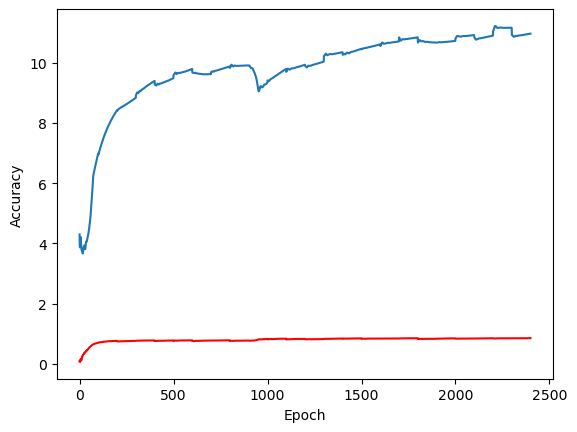

In [53]:
plt.plot(range(int(network.epochs) * 24), network.loss_history)
plt.plot(range(int(network.epochs) * 24), network.accuracy_history, color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [523]:
print(activation_layer3_forward)

[[1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 ...
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]]


In [48]:
print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 12.739091058244902
Accuracy: 0.4186166666666667


## -----------------------------------------------------------------------------------------------------------------------------

In [235]:
dense_layer1_forward = dense_layer1.forward_pass(X_train)

#print(X_train.shape[1])
#print(dense_layer1_forward.shape)

activation_layer1_forward = activation_layer1.forward_pass(dense_layer1_forward)

dense_layer2_forward = dense_layer2.forward_pass(activation_layer1_forward)

activation_layer2_forward = activation_layer2.forward_pass(dense_layer2_forward)

dense_layer3_forward = dense_layer3.forward_pass(activation_layer2_forward)

activation_layer3_forward = activation_layer3.forward_pass(dense_layer3_forward)

#print(y_test.shape)

print(activation_layer3_forward)

loss = loss_function.calculate_mean_loss(activation_layer3_forward, y_train)

print("Loss:", loss)

[[1.67590275e-06 1.65152065e-06 1.65721082e-06 ... 1.65715403e-06
  1.67848615e-06 1.67018360e-06]
 [1.67588782e-06 1.65155903e-06 1.65721330e-06 ... 1.65719159e-06
  1.67850166e-06 1.67018850e-06]
 [1.67591281e-06 1.65160950e-06 1.65722753e-06 ... 1.65719984e-06
  1.67855277e-06 1.67021450e-06]
 ...
 [1.67591354e-06 1.65152998e-06 1.65723682e-06 ... 1.65715801e-06
  1.67850356e-06 1.67018524e-06]
 [1.67590307e-06 1.65158943e-06 1.65719749e-06 ... 1.65718721e-06
  1.67852821e-06 1.67022410e-06]
 [1.67589272e-06 1.65154629e-06 1.65720792e-06 ... 1.65716691e-06
  1.67847822e-06 1.67018461e-06]]
Loss: 13.304818431623891


In [236]:
predictions = np.argmax(activation_layer3_forward, axis = 1)

accuracy = np.mean(predictions == y_train)

print("Accuracy:", accuracy)

Accuracy: 0.10218333333333333


## -----------------------------------------------------------------------------------------------------------------------------

In [1]:
class NeuralNetwork:
    
    def __init__(self, no_of_in_nodes, no_of_out_nodes, no_of_hidden_nodes, learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    
        

In [53]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

def relu(x):
    
    return np.maximum(0, x)

w1 = rng.random((image_size, hidden_layer_size))
w2 = rng.random((hidden_layer_size, output_layer_size))

print(w1.shape)

for i in range(epochs):
    
    loss = 0.0
    
    for j in range(len(X_train)):
        
        layer_0 = X_train[j]
        
        layer_1 = np.dot(layer_0, w1)
        layer_1 = relu(layer_1)
        
        layer_2 = np.dot(layer_1, w2)
    

(784, 100)
